Fitting in `slimfit` starts with model definition using standard sympy syntax.

In [1]:
from sympy import Symbol
from slimfit.models import Model

model = Model({Symbol("y"): Symbol("a") * Symbol("x") + Symbol("b")})

Generate some ground-truth data to fit to the model:

In [2]:
import numpy as np

gt = {"a": 0.5, "b": 2.5}
xdata = np.linspace(0, 11, num=100)
ydata = gt["a"] * xdata + gt["b"]

np.random.seed(43)
noise = np.random.normal(0, scale=ydata / 10.0 + 0.2)
ydata += noise

DATA = {"x": xdata, "y": ydata}

The model's parameters are a subset of the model's symbols, and are defined using a `Parameters` object.
`Parameters` objects have a shorthand constructor method to directly create parameters from a model.

In [3]:
from slimfit.parameter import Parameters
parameters = Parameters.from_symbols(model.symbols, "a b")
parameters

Parameters([Parameter(symbol=a, guess=1.0, lower_bound=None, upper_bound=None, fixed=False),
            Parameter(symbol=b, guess=1.0, lower_bound=None, upper_bound=None, fixed=False)])

The `Fit` object takes the model, parameters and data. All symbols on the model's left-hand side
(dictionary values) must be given either as parameter or data.

In [4]:
from slimfit.fit import Fit

fit = Fit(model, parameters=parameters, data=DATA)
result = fit.execute()
result.parameters

{'a': array(0.49614863), 'b': array(2.56282825)}

The fit result can be evaluated by calling the model and plotting the data together with the fit result.

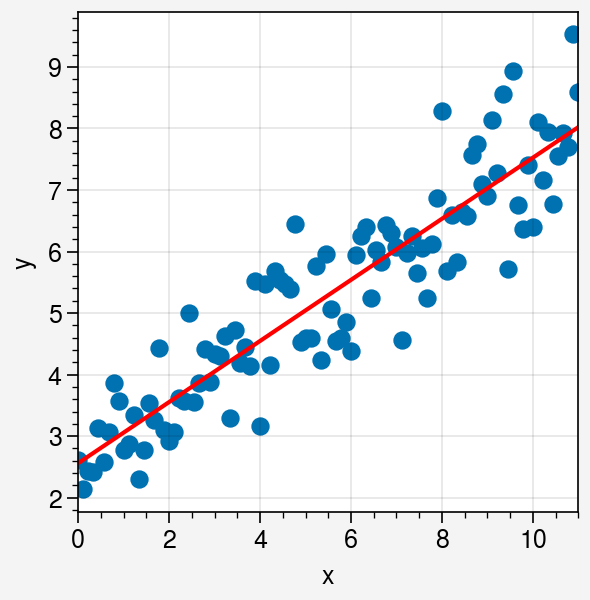

In [5]:
import proplot as pplt

fig, ax = pplt.subplots()
ax.scatter(DATA["x"], DATA["y"])
ax.plot(DATA["x"], model(**result.parameters, **DATA)["y"], color="r")
ax.format(xlabel='x', ylabel='y')
pplt.show()

Models can be expanded to include more datasets, such that parameters shared between entries are part of a global fit. The previous example can be expanded to include an additional datasets, where the symbol `b` is shared between both datasets:

In [6]:
from sympy import sin
global_model = Model({
    Symbol("y"): Symbol("a") * Symbol("x") + Symbol("b"),
    Symbol("z"): Symbol('u') * sin(Symbol('t') + Symbol('phi')) + Symbol('b'),
})
global_model

Model({y: a*x + b, z: b + u*sin(phi + t)})

Symbols (and parameters) can have arbitrary shapes such that numpy's broadcasting rules can be taken advantage of when creating models:

In [7]:
phase = np.array([0.24*np.pi, 0.8*np.pi, 1.3*np.pi]).reshape(3, 1)
u = np.array([1, 1.35, 1.45]).reshape(3, 1)
tdata = np.linspace(0, 11, num=25) + np.random.normal(size=25, scale=0.25)
zdata = u*np.sin(tdata + phase) + gt["b"]

GLOBAL_DATA = {"t": tdata, "z": zdata, **DATA}
zdata.shape

(3, 25)

The shape information has to be provided to `Fit` via the shape of parameter initial guesses. The parameters
are bounded as multiple solutions exist due to the periodicity of the sine wave.

In [8]:
from slimfit import Parameter
symbols = {s.name: s for s in global_model.symbols}
sin_parameters = Parameters([
    Parameter(symbols['phi'], guess=np.ones((3, 1)), lower_bound=0, upper_bound=2*np.pi),
    Parameter(symbols['u'], guess=np.ones((3, 1)), lower_bound=0.5)
])

In [9]:
global_parameters = parameters + sin_parameters

In [10]:
fit = Fit(global_model, parameters=global_parameters, data=GLOBAL_DATA)
global_result = fit.execute()

global_result.parameters, global_result.parameters['phi'] / np.pi

({'a': array(0.50245517),
  'b': array(2.51635028),
  'phi': array([[0.75813932],
         [2.51373612],
         [4.08108652]]),
  'u': array([[0.99862004],
         [1.35432376],
         [1.45060471]])},
 array([[0.24132324],
        [0.80014706],
        [1.29905018]]))

Due to the periodicity of the sine wave and the lack of parameter constraints, the returned parameter values differ from the ground truth, however

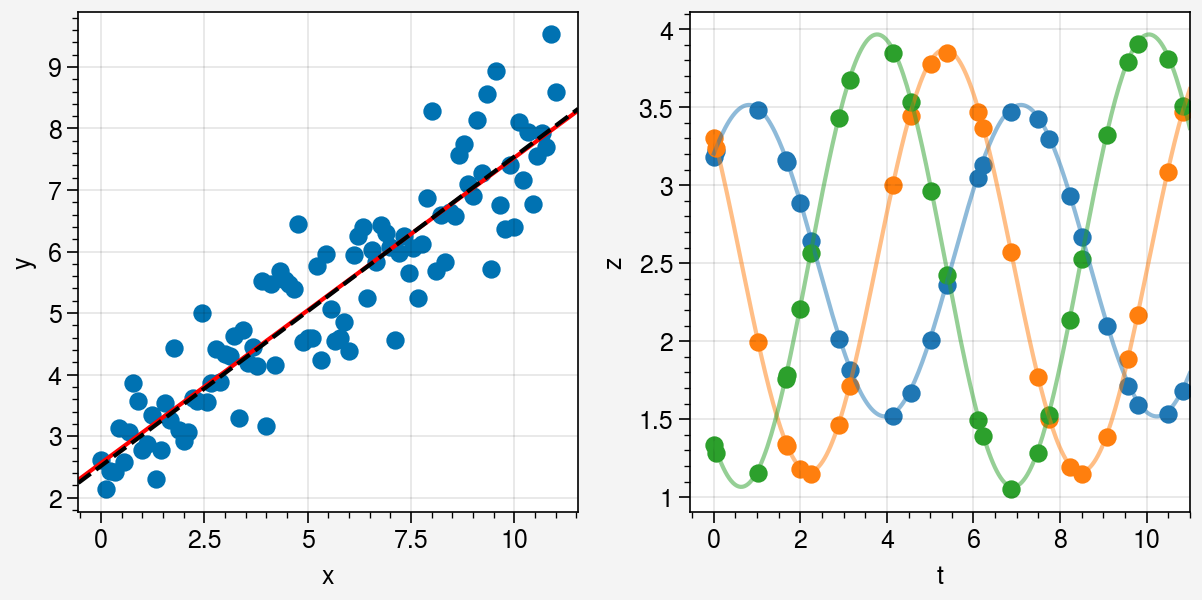

In [11]:
fix, axes = pplt.subplots(ncols=2, share=False)

axes[0].scatter(xdata, ydata)
axes[0].axline((0, result.parameters["b"]), slope=result.parameters["a"], color="r")
axes[0].axline((0, global_result.parameters["b"]), slope=global_result.parameters["a"], color="k", linestyle='--')
axes[0].format(xlabel='x', ylabel='y')

tvec = np.linspace(0, 11, num=250)
z_eval = global_model.numerical['z'](**global_result.parameters, t=tvec, f=1.2)

#ax.scatter(xdata, ydata, color='r')
axes[1].plot(tvec, z_eval.T, alpha=0.5, cycle='default')
axes[1].scatter(tdata, zdata.T)
axes[1].format(xlabel='t', ylabel='z')
pplt.show()